# Neural & Behavioral Modeling - Week 12 (Exercises)
張天瑋 B09705049

In [2]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
import torch as t
from torch import nn
from torch import optim
import random

In [49]:
# Check GPU status:
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 1.12.1+cu113
Device  0 : Tesla T4
Current: Device  0


## 1. RNN on images (4 points)
Note that the RNN-based MNIST classifier in 2.1.1 of model_12_examples.ipynb did not apply a softmax as the response function of its last layer.

Does adding a softmax make any difference in model prediciton performance? Why or why not?

Refs:

[1] https://pytorch.org/docs/stable/nn.html 

[2] https://pytorch.org/docs/stable/nn.functional.html 

[3] https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html

In [50]:
# Supporting functions:

from datetime import datetime

def setup_seed(seed):
     t.manual_seed(seed)
     t.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     t.backends.cudnn.deterministic = True

def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total


def train(device, net, train_data, valid_data, num_epochs, optimizer, criterion):
    if t.cuda.is_available():
        net = net.cuda()
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        #for im, label in train_data:
        for im, label in train_data:
            im=im.view(-1,im.shape[2],im.shape[3])
            im = im.to(device)  # (bs, h, w)
            label = label.to(device)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.data.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                with t.no_grad():
                    im=im.view(-1,im.shape[2],im.shape[3])
                    im = im.to(device)
                    label = label.to(device)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.data.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

In [51]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],std=[0.5])])

train_set = datasets.MNIST(root = "./data",
                               transform = transform,
                               train = True,
                               download = True)

train_data = t.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)


test_set = datasets.MNIST(root = "./data",
                              transform = transform,
                              train = False)

test_data = t.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [52]:
# Thoe model in 2.1.1 of 13_examples.ipynb:

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size = 28,
                                hidden_size = 128,
                                num_layers = 1,
                                batch_first = True)
        
        self.classifier = nn.Linear(128,10)
        
    def forward(self, input):
        output,_ = self.rnn(input, None)
        output = self.classifier(output[:,-1,:])
        return output

In [53]:
class RNNSoftMax(nn.Module):
    def __init__(self):
        super(RNNSoftMax, self).__init__()
        self.rnn = nn.RNN(input_size = 28,
                                hidden_size = 128,
                                num_layers = 1,
                                batch_first = True)
        
        self.classifier = nn.Linear(128,10)
        self.softmax = t.nn.Softmax()
    def forward(self, input):
        output,_ = self.rnn(input, None)
        output = self.classifier(output[:,-1,:])
        output = self.softmax(output)
        return output

In [54]:
#RNN
setup_seed(10)
srn = RNN()
optimizer = optim.Adam(srn.parameters())
criterion = nn.CrossEntropyLoss()
train(device, srn, train_data, test_data, 10, optimizer, criterion)

Epoch 0. Train Loss: 0.757581, Train Acc: 0.751599, Valid Loss: 0.410342, Valid Acc: 0.877389, Time 00:00:12
Epoch 1. Train Loss: 0.314981, Train Acc: 0.911597, Valid Loss: 0.214506, Valid Acc: 0.941182, Time 00:00:12
Epoch 2. Train Loss: 0.238294, Train Acc: 0.933436, Valid Loss: 0.206189, Valid Acc: 0.943670, Time 00:00:12
Epoch 3. Train Loss: 0.201512, Train Acc: 0.944113, Valid Loss: 0.222044, Valid Acc: 0.936604, Time 00:00:13
Epoch 4. Train Loss: 0.178142, Train Acc: 0.949394, Valid Loss: 0.193693, Valid Acc: 0.945760, Time 00:00:13
Epoch 5. Train Loss: 0.166568, Train Acc: 0.953708, Valid Loss: 0.182623, Valid Acc: 0.950438, Time 00:00:12
Epoch 6. Train Loss: 0.156001, Train Acc: 0.956690, Valid Loss: 0.169903, Valid Acc: 0.952030, Time 00:00:12
Epoch 7. Train Loss: 0.139935, Train Acc: 0.961154, Valid Loss: 0.162929, Valid Acc: 0.953822, Time 00:00:12
Epoch 8. Train Loss: 0.141573, Train Acc: 0.960271, Valid Loss: 0.136376, Valid Acc: 0.962082, Time 00:00:12
Epoch 9. Train Loss

In [55]:
#RNNWithSoftmax
setup_seed(10)
srn = RNNSoftMax()
optimizer = optim.Adam(srn.parameters())
criterion = nn.CrossEntropyLoss()
train(device, srn, train_data, test_data, 10, optimizer, criterion)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Epoch 0. Train Loss: 1.928426, Train Acc: 0.544043, Valid Loss: 1.952236, Valid Acc: 0.510848, Time 00:00:11
Epoch 1. Train Loss: 1.772329, Train Acc: 0.693130, Valid Loss: 1.685460, Valid Acc: 0.778264, Time 00:00:12
Epoch 2. Train Loss: 1.685385, Train Acc: 0.777452, Valid Loss: 1.650206, Valid Acc: 0.813396, Time 00:00:12
Epoch 3. Train Loss: 1.665969, Train Acc: 0.796658, Valid Loss: 1.633421, Valid Acc: 0.829419, Time 00:00:13
Epoch 4. Train Loss: 1.650608, Train Acc: 0.811467, Valid Loss: 1.626868, Valid Acc: 0.834693, Time 00:00:12
Epoch 5. Train Loss: 1.652759, Train Acc: 0.809118, Valid Loss: 1.634471, Valid Acc: 0.827428, Time 00:00:12
Epoch 6. Train Loss: 1.674642, Train Acc: 0.786864, Valid Loss: 1.638961, Valid Acc: 0.823049, Time 00:00:12
Epoch 7. Train Loss: 1.647999, Train Acc: 0.813499, Valid Loss: 1.626776, Valid Acc: 0.834893, Time 00:00:12
Epoch 8. Train Loss: 1.641835, Train Acc: 0.818997, Valid Loss: 1.623524, Valid Acc: 0.837082, Time 00:00:12
Epoch 9. Train Loss

增加Softmax層後並沒有使RNN模型的performance變得比較好反而還變差。可能原因為RNN模型是用累積所有圖片資訊的hidden layer當作最後一層Linear Layer的input，此時本來就已經可以很好的辨別正確答案是哪一個，而且Linear的Output是Unbounded可以為正無窮到負無窮，所以可以將正確答案和其他錯誤答案做出很顯著的分別。如果此時多加了一層softmax則會將原本Linear的output限縮在0~1中間，這將導致原本被分很開的判別結果被分的沒那麼開，導致模型的performance下降。

## 2. RNN v.s. CNN (4 points)
Compare the results of 2.2.1 (RNN) & 2.3.1 (CNN) in model_12_examples.ipynb.

The 1D-CNN seems to predict the time series better than the RNN. Why?

You may verify your hypotheses by computational experiments.

torch.Size([142, 1, 1]) (142,) 144


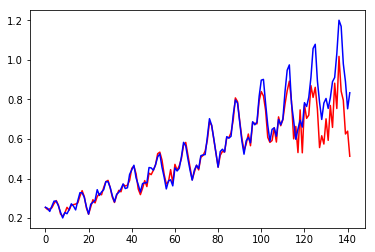

In [ ]:
# 2.2.1 (RNN):

torch.Size([142, 1]) (142,) 144


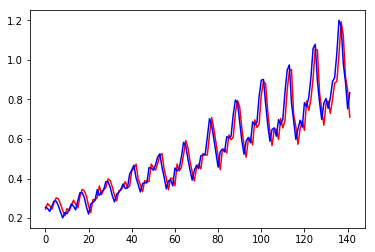

In [ ]:
# 2.3.1 (CNN):

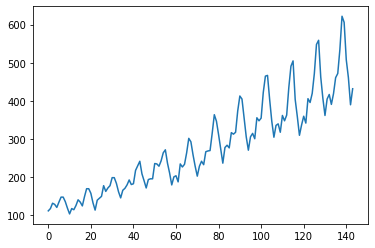

In [4]:
import pandas as pd
ts = pd.read_csv('data.csv', usecols=[1]).dropna().values.astype('float32')
plot(ts); 

144


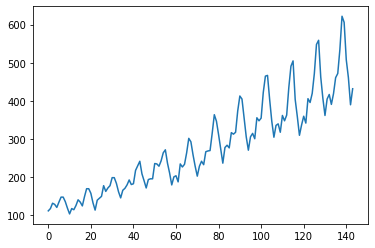

In [5]:
# Normalize:
max_value = np.max(ts)
min_value = np.min(ts)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, ts))
print(len(ts))
plot(ts); 

In [6]:
# Prepare windowed data for our RNN model(s):
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(dataset)

print(data_X[0],data_Y[0]) # (Xt-2, Xt-1) -> Xt

[[0.21621622]
 [0.22779922]] [0.25482625]


In [7]:
# Train-Test split:
train_size = int(len(data_X) * 0.7) # 70% for training
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

print(train_X.shape,train_Y.shape)

(99, 2, 1) (99, 1)


In [8]:
# Reshape the data into (seq, batch, featue)
train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

print(train_x.shape,train_y.shape)

torch.Size([99, 1, 2]) torch.Size([99, 1, 1])


In [45]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.dropout = nn.Dropout(p=0.6)
        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # flatten
        x = self.dropout(x)
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [46]:
net = lstm_reg(input_size=2, hidden_size=20)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)

In [47]:
# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data))

Epoch: 100, Loss: 0.00570
Epoch: 200, Loss: 0.00478
Epoch: 300, Loss: 0.00341
Epoch: 400, Loss: 0.00215
Epoch: 500, Loss: 0.00194
Epoch: 600, Loss: 0.00203
Epoch: 700, Loss: 0.00231
Epoch: 800, Loss: 0.00225
Epoch: 900, Loss: 0.00299
Epoch: 1000, Loss: 0.00191


torch.Size([142, 1, 1]) (142,) 144


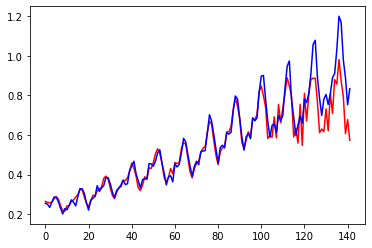

In [48]:
# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
data_X2 = data_X.reshape(-1, 1, 2)
data_X3 = t.from_numpy(data_X2)
pred_test1 = net(data_X3) 
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(dataset))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(dataset[2:], 'b', label='real');

In [ ]:
#CNN

In [56]:
print(data_X.shape, data_Y.shape) # (seq, feature, batch)

(142, 2, 1) (142, 1)


In [57]:
# Train-Test split:
data_X4 = np.swapaxes(data_X,1,2) # should be (batch, channel, input)
L=data_X4.shape[0]
train_size = int(L * 0.7) # 70% for training
test_size = L - train_size
train_X = data_X4[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X4[train_size:]
test_Y = data_Y[train_size:]

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

print(train_x.shape,train_y.shape) # (batch,input,feature)

torch.Size([99, 1, 2]) torch.Size([99, 1])


In [58]:
class cnn_reg(nn.Module):
    def __init__(self, in_channels, hidden_size, output_size, kernel_size):
        super(cnn_reg, self).__init__()
        
        self.conv = nn.Conv1d(in_channels=in_channels, out_channels=hidden_size, kernel_size=kernel_size) # in_channels=features

        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x = self.conv(x) # (batch, channel, input)
        x=x.view(x.size()[0], -1) # flatten
        x = self.reg(x)
        return x

In [59]:
net = cnn_reg(in_channels=1, hidden_size=10, output_size=1, kernel_size=2)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)

In [60]:
# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data))

Epoch: 100, Loss: 0.00236
Epoch: 200, Loss: 0.00217
Epoch: 300, Loss: 0.00203
Epoch: 400, Loss: 0.00195
Epoch: 500, Loss: 0.00191
Epoch: 600, Loss: 0.00190
Epoch: 700, Loss: 0.00190
Epoch: 800, Loss: 0.00190
Epoch: 900, Loss: 0.00190
Epoch: 1000, Loss: 0.00190


torch.Size([142, 1]) (142,) 144


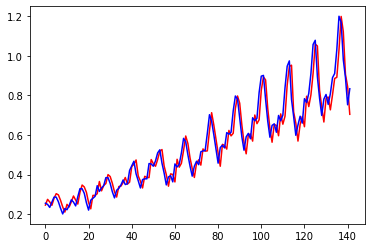

In [61]:
# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
pred_test1 = net(t.from_numpy(data_X4))
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(dataset))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(dataset[2:], 'b', label='real');

根據實驗結果推測，CNN能表現得好是因為他能找到拐點出現的特徵，而LSTM表現不好是因為整個資料有非常均勻的高度相關性，這會導致LSTM很容易OverFitting。
我們可以從LSTM前面training data都預測的很好到後面testing時變差判斷出有overfitting的問題，所以我有試著加入dropout層讓模型不要太overfit，不過仍然無法和CNN有相同的預測表現。

In [63]:
%%shell
jupyter nbconvert --to html ./model_12_exercises.ipynb

[NbConvertApp] Converting notebook ./model_12_exercises.ipynb to html
[NbConvertApp] Writing 536273 bytes to ./model_12_exercises.html
